This script generates hillslope mesh with a varying organic layer thickness at the top.

In [1]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing_ats'))
import meshing_ats

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# of x and z elements:  101 ,  101
# of cells:  100


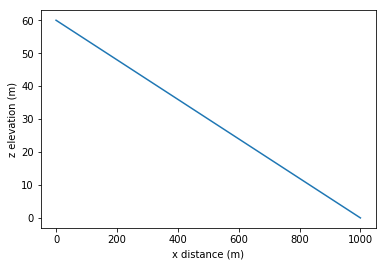

In [2]:
# 1 km long hillslope, 10% slope
x = np.linspace(0,1000,101)
z = 60 - 0.06*x
print '# of x and z elements: ',len(x),', ',len(z)
plt.plot(x,z); plt.xlabel('x distance (m)'); plt.ylabel('z elevation (m)')
m2 = meshing_ats.Mesh2D.from_Transect(x,z)
print '# of cells: ', m2.num_cells()

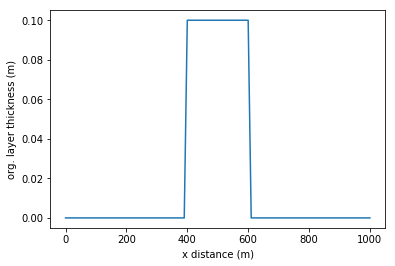

In [4]:
# Changing organic layer thickness 
def impervious_thickness(x):
    """This function is the thickness of the parking lot as a function of x"""
    if x < 400:
        thickness = 0.
    elif x > 600:
        thickness = 0.
    else:
        thickness = 0.1
    return thickness

patch_thickness = np.array([impervious_thickness(xx) for xx in m2.coords[:,0]])
plt.plot(x, patch_thickness[0:101]); plt.xlabel('x distance (m)'); plt.ylabel('org. layer thickness (m)');


In [57]:
# preparing layer extrusion data for meshing_ats
#
# Meshes are extruded in the vertical by "layer", where a layer may 
# consist of multiple cells in the z direction.  These layers are 
# logical unit to make construction easier, and may or may not 
# correspond to material type (organic/mineral soil).
# 
# The extrusion process is then given four lists, each of length
# num_layers.
#
layer_types = []  # a list of strings that tell the extruding 
                  # code how to do the layers.  See meshing_ats 
                  # documentation for more, but here we will use
                  # only "constant", which means that dz within
                  # the layer is constant.

layer_data = []   # this data depends upon the layer type, but
                  # for constant is the thickness of the layer

layer_ncells = [] # number of cells (in the vertical) in the layer.
                  # The dz of each cell is the layer thickness / number of cells.

layer_mat_ids = []# The material ID.  This may be either a constant int (for
                  # unform layering) or an array of size [ncells_vertical x ncells_horizontal] in the layer 
                  # where each entry corresponds to the material ID of that cell.

layer_depth = []  # used later to get the mat ids right, just for bookkeeping
        
# here we will only use 1 cell per layer, so layer thickness = dz.
# We will also telescope the mesh, starting at 1cm grid cell and growing it larger in each layer.
dz = .05
i = 0
current_depth = 0

# mixed soil/parking lot layer
dz = 0.1
layer_types.append("constant")
layer_data.append(dz)
layer_ncells.append(2)
current_depth += dz
i += 2


# allocate 1D matrix with cols=#cells
layer_mat_ids = np.zeros((m2.num_cells(), 12+22), 'i')

for j in range(100):
    x_cell = (m2.coords[j,0] + m2.coords[j+1,0]) / 2.0
    if (x_cell < 400) or (x_cell > 600):
        layer_mat_ids[j,0:i] = 1001
    else:
        layer_mat_ids[j,0:i] = 1002
#layer_mat_ids.append(mat_ids)
    
print layer_mat_ids
    
# here we will only use 1 cell per layer, so layer thickness = dz.
# We will also telescope the mesh, starting at 1cm grid cell and growing it larger in each layer.
dz = .05

while i < 11:
    dz *= 1.51
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    current_depth += dz
    #layer_depth.append(current_depth)
    layer_mat_ids[:,i] = 1001
    i += 1
    
    
# now add in a bunch of cells to reach 45 m, of equal dz that is ~2m.
#num_of_layers=len(layer_data)
layer_types.append("constant")
layer_data.append(50 - sum(layer_data))  # note sum(layer_data) == the total mesh thickness at this point
layer_ncells.append(22)
layer_mat_ids[:,i:] = 1001


[[1001 1001    0 ...    0    0    0]
 [1001 1001    0 ...    0    0    0]
 [1001 1001    0 ...    0    0    0]
 ...
 [1001 1001    0 ...    0    0    0]
 [1001 1001    0 ...    0    0    0]
 [1001 1001    0 ...    0    0    0]]


In [58]:
print current_depth
print layer_data
print len (layer_data)
print layer_mat_ids.min()

5.99380191209
[0.1, 0.07550000000000001, 0.11400500000000002, 0.17214755000000004, 0.25994280050000007, 0.3925136287550001, 0.5926955794200501, 0.8949703249242758, 1.3514051906356563, 2.0406218378598413, 44.006198087905176]
11
1001


In [59]:
# make the mesh, save it as an exodus file
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types,layer_data, layer_ncells, layer_mat_ids)
m3.write_exodus("test_parkinglot.exo")

IndexError: index 34 is out of bounds for axis 1 with size 34

In [7]:
# Make a column that is the same as the deepest organic layer thickness for use in spinup.
# 1 km long hillslope, 10% slope
xc = np.array([0,1])
zc = np.array([0,0])
m2c = meshing_ats.Mesh2D.from_Transect(xc,zc)
print '# of cells: ', m2c.num_cells()

# of cells:  1


In [8]:
column_mat_ids = [lmi[50] for lmi in layer_mat_ids]
print column_mat_ids

[1001, 1001, 1001, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101]


In [9]:
m3c = meshing_ats.Mesh3D.extruded_Mesh2D(m2c, layer_types,layer_data, layer_ncells, column_mat_ids)
m3c.write_exodus("test_organic_highres_column.exo")


You are using exodus.py v 1.05 (beta-cmake), a python wrapper of some of the exodus II library.

Copyright (c) 2013, 2014, 2015, 2016, 2017 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.  

Opening exodus file: test_organic_highres_column.exo
Closing exodus file: test_organic_highres_column.exo
